In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

In [2]:
from pycrn import *

In [3]:
def dual_encode(val): 
    return (max(0, val), max(0, -val))

def dual_decode(p_val, n_val): 
    return p_val - n_val


y_pred_p before bias: 0.0, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0, y_pred_n before bias: 0.0
y_pred_p before bias: 1.969089715245611e-05, y_pred_n before bias: 0.0
y_pred_p before bias: 9.102123448981494e-05, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0002654059465686778, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0005366741225659488, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0007525912521256505, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0011885874004256153, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0016164897899311266, y_pred_n before bias: 0.0
y_pred_p before bias: 0.002138813543346865, y_pred_n before bias: 0.0
y_pred_p before bias: 0.002849191172003658, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0036161585219693575, y_pred_n before bias: 0.0
y_pred_p before bias: 0.004844611340959159, y_pred_n before bias: 0.0
y_pred_p before bias: 0.0060148130546098496, y_pred_n before bias: 0.0
y_pred_p before bias: 0.007080187140839403, y

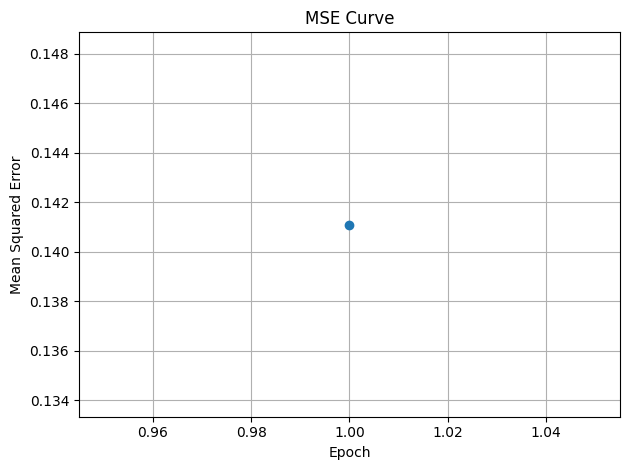

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def linear_regression_dual_normal(X, Y, lr=0.1, epochs=3):
    X = np.array(X, dtype=float)
    Y = np.array(Y, dtype=float)

    n, d = X.shape

    w_p = np.zeros(d)
    w_n = np.zeros(d)

    b_p = 0.0
    b_n = 0.0

    mse_curve = []

    for epoch in range(epochs):
        total_loss = 0.0

        for i in range(n):
            xi = X[i]
            x_p = np.maximum(xi, 0)
            x_n = np.maximum(-xi, 0)

            # dual encode target yi
            yi_val = Y[i]
            yi_p = max(yi_val, 0)
            yi_n = max(-yi_val, 0)

            # DOT PRODUCT:  y_pred = sum(w[j] * x[j]) + b

            y_pred_p = 0.0
            y_pred_n = 0.0

            for j in range(d):
                # decode w[j] from dual rail
                # wj = w_p[j] - w_n[j]
                # decode x[j]
                # xj = x_p[j] - x_n[j]
                # y_pred += wj * xj
                # y_pred_p += w_p[j] * x_p[j] + w_n[j] * x_n[j]
                a1 = w_p[j] * x_p[j]
                a2 = w_n[j] * x_n[j]
                # print(f"a1: {a1}, a2: {a2}")
                y_pred_p += a1 + a2
                y_pred_n += w_p[j] * x_n[j] + w_n[j] * x_p[j]

            # add bias
            #) y_pred += (b_p - b_n)
            print(f"y_pred_p before bias: {y_pred_p}, y_pred_n before bias: {y_pred_n}")
            y_pred_p += b_p
            y_pred_n += b_n
            y_pred = y_pred_p - y_pred_n

            # ERROR: err = y_pred - yi  (dual rail)
            # err = y_pred - (yi_p - yi_n)
            # err_p = y_pred_p + yi_n
            # err_n = yi_n
            err_p = y_pred_p+ yi_n
            err_n = y_pred_n + yi_p
            err = err_p - err_n

            # DB UPDATE 
            # db = 2*err
            db_val = err
            db_p = max(db_val, 0)
            db_n = max(-db_val, 0)

            # update b = b - lr*db
            # sub_val = lr * db_val
            # sub_p = max(sub_val, 0)
            # sub_n = max(-sub_val, 0)
            sub_p = lr * db_p
            sub_n = lr * db_n

            b_p = b_p + sub_n
            b_n = b_n + sub_p

            # WEIGHT UPDATE (dual):
            # w[j] = w[j] - lr * 2 * err * x[j]
            for j in range(d):
                # decode x[j]
                xj = x_p[j] - x_n[j]

                grad = err * xj
                grad_val = lr * grad

                g_p = max(grad_val, 0)
                g_n = max(-grad_val, 0)

                # w = w - grad
                w_p[j] = w_p[j] + g_n
                w_n[j] = w_n[j] + g_p

            total_loss += err * err

        mse_curve.append(total_loss / n)

    # final decoded parameters
    w_real = w_p - w_n
    b_real = b_p - b_n

    return mse_curve, w_real, b_real
np.random.seed(0)
X = np.linspace(0, 1, 100).reshape(-1,1)
Y = 2*X.squeeze() + 1 + 0.2*np.random.randn(100)
# print("X")
# print(X)
# print("Y")
# print(Y)

mse_curve, w_real, b_real = linear_regression_dual_normal(X, Y, lr=0.1, epochs=1)

print("w =", w_real)
print("b =", b_real)

plt.figure()
plt.plot(range(1, len(mse_curve)+1), mse_curve, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

# np.random.seed(0)
# X = np.linspace(0, 1, 100).reshape(-1,1)
# Y = 2*X.squeeze() + 1 + 0.2*np.random.randn(100)
# # print("X")
# # print(X)
# # print("Y")
# # print(Y)

# mse_curve, w_real, b_real = linear_regression_dual_normal(X, Y, lr=0.1, epochs=100)


# print("w =", w_real)
# print("b =", b_real)

# plt.figure()
# plt.plot(range(1, len(mse_curve)+1), mse_curve, marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.title('MSE Curve')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# ---- test ----
# np.random.seed(0)
# X = np.linspace(0, 1, 100).reshape(-1,1)
# Y = 2*X.squeeze() + 1 + 0.2*np.random.randn(100)
# # print("X")
# # print(X)
# # print("Y")
# # print(Y)

# mse_curve, w_real, b_real = linear_regression_dual_normal(X, Y, lr=0.1, epochs=1)

# print("w =", w_real)
# print("b =", b_real)

# plt.figure()
# plt.plot(range(1, len(mse_curve)+1), mse_curve, marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.title('MSE Curve')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]


FINAL ODE SYSTEM
da1_0_0_0/dt = + 1 * (1.0 * o2 * w_p_0_0_0 * x_pj_0_0_0) - 1 * (1.0 * o2 * a1_0_0_0)
da2_0_0_0/dt = + 1 * (1.0 * o2 * w_n_0_0_0 * x_nj_0_0_0) - 1 * (1.0 * o2 * a2_0_0_0)
db1_0_0_0/dt = + 1 * (1.0 * o2 * w_p_0_0_0 * x_nj_0_0_0) - 1 * (1.0 * o2 * b1_0_0_0)
db2_0_0_0/dt = + 1 * (1.0 * o2 * w_n_0_0_0 * x_pj_0_0_0) - 1 * (1.0 * o2 * b2_0_0_0)
db_n_0_0/dt = 0
db_p_0_0/dt = 0
dc_0_0_0/dt = + 1 * (1.0 * o4 * a1_0_0_0) + 1 * (1.0 * o4 * y_pred_p_0_0) - 1 * (1.0 * o4 * c_0_0_0)
dd_0_0_0/dt = + 1 * (1.0 * o4 * b1_0_0_0) + 1 * (1.0 * o4 * y_pred_n_0_0) - 1 * (1.0 * o4 * d_0_0_0)
do1/dt = - 1 * (1.0 * o1 * o2) + 1 * (1.0 * o10 * o1)
do10/dt = + 1 * (1.0 * o9 * o10) - 1 * (1.0 * o10 * o1)
do2/dt = + 1 * (1.0 * o1 * o2) - 1 * (1.0 * o2 * o3)
do3/dt = + 1 * (1.0 * o2 * o3) - 1 * (1.0 * o3 * o4)
do4/dt = + 1 * (1.0 * o3 * o4) - 1 * (1.0 * o4 * o5)
do5/dt = + 1 * (1.0 * o4 * o5) - 1 * (1.0 * o5 * o6)
do6/dt = + 1 * (1.0 * o5 * o6) - 1 * (1.0 * o6 * o7)
do7/dt = + 1 * (1.0 * o6 * o7) - 

100%|██████████| 1/1 [00:30<00:00, 30.00s/it]

y_pred_p before bias: 3.3797245357235206, y_pred_n before bias: 0.3389723272388682
w = [0.7282539]
b = 2.32042739217772


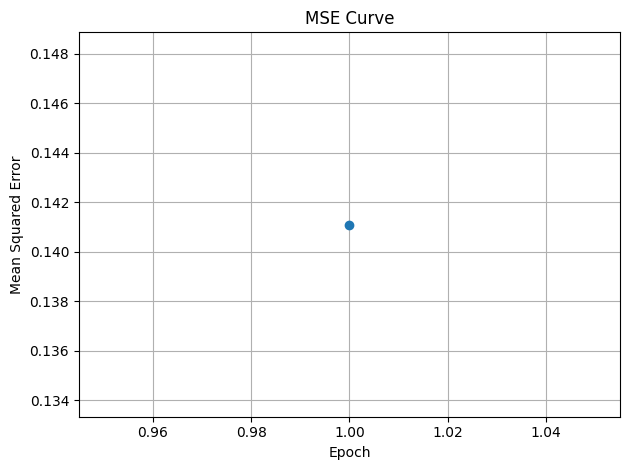

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def linear_regression_dual_normal(X, Y, lr=0.1, epochs=3):
    X = np.array(X, dtype=float)
    Y = np.array(Y, dtype=float)

    n, d = X.shape

    w_p = np.zeros(d)
    w_n = np.zeros(d)
    # crn = CRNCompiler(oscillator_step=2) 

    # bias in dual rail
    b_p = 0.0
    b_n = 0.0

    mse_curve = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0.0

        for i in range(n):
            xi = X[i]
            # x_p, x_n = dual_encode(xi)
            x_p = np.maximum(xi, 0)
            x_n = np.maximum(-xi, 0)

            # dual encode target yi
            yi_val = Y[i]
            yi_p = max(yi_val, 0)
            yi_n = max(-yi_val, 0)

            # DOT PRODUCT:  y_pred = sum(w[j] * x[j]) + b
            # y_pred_p = 0.0
            # y_pred_n = 0.0
            # y_pred = 0.0

            crn = CRNCompiler(oscillator_step=2)
            for j in range(d):
                # decode w[j] from dual rail
                # wj = w_p[j] - w_n[j]
                # decode x[j]
                # xj = x_p[j] - x_n[j]
                # y_pred += wj * xj
                # a1 =  w_p[j] * x_p[j]
                # a2 = w_n[j] * x_n[j]
                
                crn.add_phase([
                    ('mul', (f'w_p_{epoch}_{i}_{j}', w_p[j]), (f'x_pj_{epoch}_{i}_{j}', x_p[j]), f'a1_{epoch}_{i}_{j}'),
                    ('mul', (f'w_n_{epoch}_{i}_{j}', w_n[j]), (f'x_nj_{epoch}_{i}_{j}', x_n[j]), f'a2_{epoch}_{i}_{j}'),
                    ('mul', (f'w_p_{epoch}_{i}_{j}', w_p[j]), (f'x_nj_{epoch}_{i}_{j}', x_n[j]), f'b1_{epoch}_{i}_{j}'),
                    ('mul', (f'w_n_{epoch}_{i}_{j}', w_n[j]), (f'x_pj_{epoch}_{i}_{j}', x_p[j]), f'b2_{epoch}_{i}_{j}')
                ])
                # sol, s_map = crn.simulate(t_max=3000, steps=20000)
                # y_pred_n += w_p[j] * x_n[j] + w_n[j] * x_p[j]
                # a1 = crn.get_value(sol, s_map, f'a1_{epoch}_{i}_{j}')
                # a2 = crn.get_value(sol, s_map, f'a2_{epoch}_{i}_{j}')
                # b1 = crn.get_value(sol, s_map, f'b1_{epoch}_{i}_{j}')
                # b2 = crn.get_value(sol, s_map, f'b2_{epoch}_{i}_{j}')
                # print(f"a1: {a1}, a2: {a2}")
                # y_pred_p += a1 + a2
                crn.add_phase([
                    ('add', f'a1_{epoch}_{i}_{j}', f'y_pred_p_{epoch}_{i}', f'c_{epoch}_{i}_{j}'),
                    ('add', f'b1_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}', f'd_{epoch}_{i}_{j}')
                ])
                crn.add_phase([
                        ('add', f'c_{epoch}_{i}_{j}', f'a2_{epoch}_{i}_{j}', f'y_pred_p_{epoch}_{i}'),
                        ('add', f'd_{epoch}_{i}_{j}', f'b2_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}')
                        # ('add', f'b1_{epoch}_{i}_{j}', f'b2_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}')
                ])
                    # crn.add_phase([
                    #     ('add', f'a2_{epoch}_{i}_{j}',(f'y_pred_p_{epoch}_{i}',0), f'y_pred_p_{epoch}_{i}'),
                    #     ('add', f'b2_{epoch}_{i}_{j}', (f'y_pred_n_{epoch}_{i}',0), f'y_pred_n_{epoch}_{i}')
                    # ])

                # if j == 0:
                #     crn.add_phase([
                #         ('add', f'a1_{epoch}_{i}_{j}', (f'y_pred_p_{epoch}_{i}',0), f'y_pred_p_{epoch}_{i}'),
                #         ('add', f'b1_{epoch}_{i}_{j}', (f'y_pred_n_{epoch}_{i}',0), f'y_pred_n_{epoch}_{i}')
                #         # ('add', f'b1_{epoch}_{i}_{j}', f'b2_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}')
                #     ])
                #     crn.add_phase([
                #         ('add', f'a2_{epoch}_{i}_{j}',(f'y_pred_p_{epoch}_{i}',0), f'y_pred_p_{epoch}_{i}'),
                #         ('add', f'b2_{epoch}_{i}_{j}', (f'y_pred_n_{epoch}_{i}',0), f'y_pred_n_{epoch}_{i}')
                #     ])
                # else:
                #     # print("BLABLA")
                #     crn.add_phase([
                #         ('add', f'a1_{epoch}_{i}_{j}', f'y_pred_p_{epoch}_{i}', f'y_pred_p_{epoch}_{i}'),
                #         ('add', f'b1_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}', f'y_pred_n_{epoch}_{i}')
                #         # ('add', f'b1_{epoch}_{i}_{j}', f'b2_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}')
                #     ])
                #     crn.add_phase([
                #         ('add', f'a2_{epoch}_{i}_{j}', f'y_pred_p_{epoch}_{i}', f'y_pred_p_{epoch}_{i}'),
                #         ('add', f'b2_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}', f'y_pred_n_{epoch}_{i}')
                #     ])
                
                # y_pred_n += b1 + b2
                # crn.add_phase([
                #     ('add', f'a1_{epoch}_{i}_{j}', f'a2_{epoch}_{i}_{j}', f'y_pred_p_{epoch}_{i}'),
                #     ('add', f'b1_{epoch}_{i}_{j}', f'b2_{epoch}_{i}_{j}', f'y_pred_n_{epoch}_{i}')
                # ])

            # add bias
            crn.add_phase([
                ('add', f'y_pred_p_{epoch}_{i}', (f'b_p_{epoch}_{i}', b_p), f'y_pred_dash_p_{epoch}_{i}'),
                ('add', f'y_pred_n_{epoch}_{i}', (f'b_n_{epoch}_{i}', b_n), f'y_pred_dash_n_{epoch}_{i}')
            ])  
            # crn.add_phase([
            #     ('ld', (f'c_{epoch}_{i}',), f'y_pred_p_{epoch}_{i}'),
            #     ('ld', (f'd_{epoch}_{i}',), f'y_pred_n_{epoch}_{i}')
            # ])
            sol, s_map = crn.simulate(t_max=3000, steps=20000)
            # y_pred_p = crn.get_value(sol, s_map, f'_pred_p_{epoch}_{i}')
            # y_pred_n = crn.get_value(sol, s_map, f'_pred_n_{epoch}_{i}')
            y_pred_p = crn.get_value(sol, s_map, f'y_pred_dash_p_{epoch}_{i}')
            y_pred_n = crn.get_value(sol, s_map, f'y_pred_dash_n_{epoch}_{i}')
            y_pred = y_pred_p - y_pred_n
            print(f"y_pred_p before bias: {y_pred_p}, y_pred_n before bias: {y_pred_n}")
            # y_pred_p += b_p
            # y_pred_n += b_n
            # y_pred += (b_p - b_n)
            # y_pred_p += b_p
            # y_pred_n += b_n
            # crn.add_phase([
            #     ('add', (f'y_pred_p_{epoch}_{i}', b_p), (f'y_pred_n_{epoch}_{i}', b_n), f'y_pred_p_{epoch}_{i}'),
            #     ('add', (f'y_pred_n_{epoch}_{i}', b_n), (f'y_pred_p_{epoch}_{i}', b_p), f'y_pred_n_{epoch}_{i}')
            # ])
            # y_pred = y_pred_p - y_pred_n

            # ERROR: err = y_pred - yi  (dual rail)

            # err = y_pred - (yi_p - yi_n)
            # err_p = y_pred_p + yi_n
            # err_n = yi_n
            # crn.add_phase([
            #     ('add', (f'y_pred_p_{epoch}_{i}',), (f'y_pred_n_{epoch}_{i}'), f'err_p_{epoch}_{i}'),
            #     ('add', (f'y_pred_n_{epoch}_{i}'), (f'y_pred_p_{epoch}_{i}'), f'err_n_{epoch}_{i}')
            # ])
            # sol, s_map = crn.simulate(t_max=3000, steps=20000)
            # err_p = crn.get_value(sol, s_map, f'err_p_{epoch}_{i}')
            # err_n = crn.get_value(sol, s_map, f'err_n_{epoch}_{i}')
            # err = err_p - err_n
            # y_pred_p = crn.get_value(sol, s_map, f'y_pred_p_{epoch}_{i}')
            # y_pred_n = crn.get_value(sol, s_map, f'y_pred_n_{epoch}_{i}')

            err_p = y_pred_p+ yi_n
            err_n = y_pred_n + yi_p
            err = err_p - err_n

            # DB UPDATE
            # db = 2*err
            db_val = err
            db_p = max(db_val, 0)
            db_n = max(-db_val, 0)

            # update b = b - lr*db
            # sub_val = lr * db_val
            # sub_p = max(sub_val, 0)
            # sub_n = max(-sub_val, 0)
            sub_p = lr * db_p
            sub_n = lr * db_n

            b_p = b_p + sub_n
            b_n = b_n + sub_p

            # w[j] = w[j] - lr * 2 * err * x[j]
            for j in range(d):
                # decode x[j]
                xj = x_p[j] - x_n[j]

                grad = err * xj
                grad_val = lr * grad

                g_p = max(grad_val, 0)
                g_n = max(-grad_val, 0)

                # w = w - grad
                w_p[j] = w_p[j] + g_n
                w_n[j] = w_n[j] + g_p

            total_loss += err * err

        mse_curve.append(total_loss / n)

    w_real = w_p - w_n
    b_real = b_p - b_n

    return mse_curve, w_real, b_real


np.random.seed(0)
X = np.linspace(0, 1, 100).reshape(-1,1)
Y = 2*X.squeeze() + 1 + 0.2*np.random.randn(100)
# print("X")
# print(X)
# print("Y")
# print(Y)

mse_curve, w_real, b_real = linear_regression_dual_normal(X, Y, lr=0.1, epochs=1)

print("w =", w_real)
print("b =", b_real)

plt.figure()
plt.plot(range(1, len(mse_curve)+1), mse_curve, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Curve')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
crn = CRNCompiler(oscillator_step=2)
crn.add_phase([
    ('mul', ('xx    ', 3), ('x_pj', 4), 'a1'),
    ('mul', ('yy', 2), ('x_nj', 5), 'a2')
])
sol, s_map = crn.simulate()
a1 = crn.get_value(sol, s_map, 'a1')
a2 = crn.get_value(sol, s_map, 'a2')
print(f"a1: {a1}, a2: {a2}")



FINAL ODE SYSTEM
da1/dt = + 1 * (1.0 * o2 * xx     * x_pj) - 1 * (1.0 * o2 * a1)
da2/dt = + 1 * (1.0 * o2 * yy * x_nj) - 1 * (1.0 * o2 * a2)
do1/dt = - 1 * (1.0 * o1 * o2) + 1 * (1.0 * o4 * o1)
do2/dt = + 1 * (1.0 * o1 * o2) - 1 * (1.0 * o2 * o3)
do3/dt = + 1 * (1.0 * o2 * o3) - 1 * (1.0 * o3 * o4)
do4/dt = + 1 * (1.0 * o3 * o4) - 1 * (1.0 * o4 * o1)
dtrash1/dt = + 1 * (1.0 * o2 * a1)
dtrash2/dt = + 1 * (1.0 * o2 * a2)
dx_nj/dt = 0
dx_pj/dt = 0
dxx    /dt = 0
dyy/dt = 0


a1: 12.00000000045242, a2: 10.000000000363485
